In [6]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import matplotlib.pylab as mplot
import yaml
import h5py
import healpy as hp
# import healsparse as hs
import scipy
from scipy import interpolate

%matplotlib inline

# mplot.rc('text', usetex=True)
# mplot.rc('font', family='serif')


matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Times New Roman"


In [2]:
tag = '0613'
project_dir = '/project/chihway/data/decade/'

In [3]:
# first get mask total

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    sg = h5r['sg_bdf'][:] 
    fg = h5r['FLAGS_FOREGROUND'][:] 
    T = h5r['mcal_T_noshear'][:]
    mcal_flags = h5r['mcal_flags'][:]
    g1, g2  = h5r['mcal_g_noshear'][:].T
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear'][:].T

mag_r = -2.5*np.log10(flux_r)+30
mag_i = -2.5*np.log10(flux_i)+30
mag_z = -2.5*np.log10(flux_z)+30

# PZ mask
mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SNR_Mask   = (s2n > 10) & (s2n < 1000)
Tratio_Mask= size_ratio > 0.5
T_Mask = T < 10
Flag_Mask = (mcal_flags == 0)
Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
SG_Mask = (sg>=4)
FG_Mask = (fg==0)

mask_total = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask

/home/chihway/ipykernel_944640/3314824022.py:13: RuntimeWarning: invalid value encountered in log10
  mag_r = -2.5*np.log10(flux_r)+30
/home/chihway/ipykernel_944640/3314824022.py:14: RuntimeWarning: invalid value encountered in log10
  mag_i = -2.5*np.log10(flux_i)+30
/home/chihway/ipykernel_944640/3314824022.py:15: RuntimeWarning: invalid value encountered in log10
  mag_z = -2.5*np.log10(flux_z)+30
/home/chihway/ipykernel_944640/3314824022.py:29: RuntimeWarning: invalid value encountered in log10
  Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))


Text(0.5, 0, 'i mag')

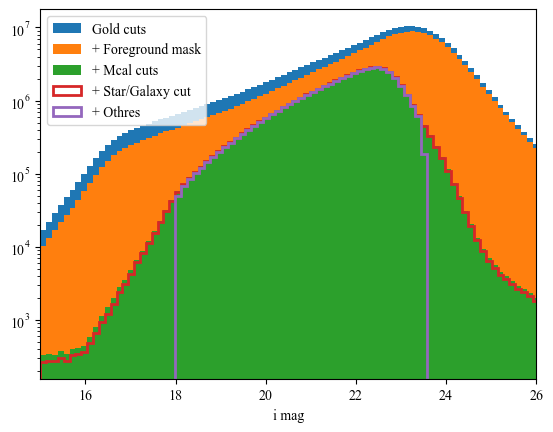

In [7]:
mplot.hist(mag_i, bins=100, range=(15,28), label='Gold cuts')
mplot.hist(mag_i[FG_Mask], bins=100, range=(15,28), label='+ Foreground mask')
mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask], bins=100, range=(15,28), label='+ Mcal cuts')
mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask], bins=100, range=(15,28), label='+ Star/Galaxy cut', histtype='step', lw=2)
mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask*T_Mask*Other_Mask*mcal_pz_mask], bins=100, range=(15,28), label='+ Othres', histtype='step', lw=2)

mplot.legend()
mplot.xlim(15,26)
mplot.yscale('log')
mplot.xlabel('i mag')


In [8]:
# !echo $PATH

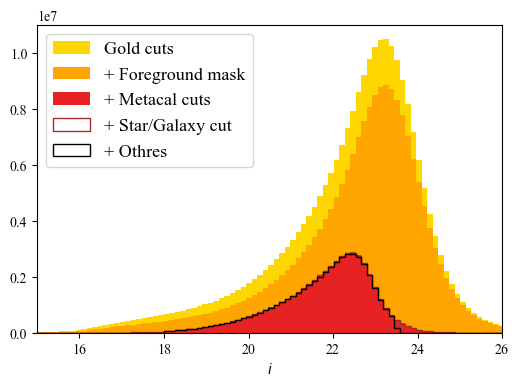

In [21]:
mplot.figure(figsize=(6,4))
mplot.hist(mag_i, bins=100, range=(15,28), label='Gold cuts', color='gold')
mplot.hist(mag_i[FG_Mask], bins=100, range=(15,28), label='+ Foreground mask', color='orange')
mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask], bins=100, range=(15,28), label='+ Metacal cuts', color='#e72222')
mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask], bins=100, range=(15,28), label='+ Star/Galaxy cut', histtype='step', lw=1, color='brown')
mplot.hist(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask*T_Mask*Other_Mask*mcal_pz_mask], bins=100, range=(15,28), label='+ Othres', histtype='step', lw=1, color='k') 

mplot.legend(fontsize=13)
mplot.xlim(15,26)
mplot.xlabel('$i$')

mplot.savefig('mag_dist_cuts.pdf', bbox_inches='tight')


In [18]:
print(len(mag_i))
print(len(mag_i[FG_Mask]))
print(len(mag_i[FG_Mask*SNR_Mask*Tratio_Mask]))
print(len(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask]))
print(len(mag_i[FG_Mask*SNR_Mask*Tratio_Mask*SG_Mask*T_Mask*Other_Mask*mcal_pz_mask]))


244200019
196160670
49841218
49586959
47349243


In [25]:
print(len(mag_i))
print(len(mag_i[FG_Mask]))
print(len(mag_i[SNR_Mask*Tratio_Mask]))
print(len(mag_i[SG_Mask]))
print(len(mag_i[T_Mask*Other_Mask*mcal_pz_mask]))


244200019
196160670
59938572
146535714
163033587


In [19]:
49586959/49841218

0.9948986198531504

In [31]:
163033587/244200019

0.6676231544437349

In [24]:
49841218/244200019

0.2040999759299773

In [ ]:
# should probably code this up...